By:  David R. Torres<br>
Flatiron School<br>
Github repo: https://github.com/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/tree/master

# **Using an ARIMA Model for Time Series Forecasting**

### **Introduction**
Business Problem: I am a consultant for the investment firm Premium Real Estate, LLC.  The firm is interested in investing in the Brooklyn real estate market.  The firm asked me to provide an analysis and make recommendations for investing in real estate in the top 5 zipcodes in Brooklyn, NY.   I used time series forecasting analysis and models to predict the 5 best zip codes to invest in Brooklyn.  I decided that the top zip codes for investment would be ones that offer a high return on investment (ROI).  The ROI will be based on the real estate prices in Brooklyn.  The firm is looking for short-term investments with the highest returns over a 3 year period.  The 'top 5 zipcodes' would be those with the highest ROI over a 3 year period.<br>
<br>
For the task, I analyzed real estate sales data from Zillow which covers the time period 4-1-1996 to 4-1-2018.<br>
I used an Auto Arima model to conduct a gridsearch to find the p,d,qs and Seasonal P,D,Qs with the lowest related AIC scores for each zipcode.  I used a SARIMA model to make predictions regarding the test data.  I used the metric RMSE to evaluate how the models performed in making predictons.  I then made models to perform dynamic forecasts for 3 years.<br>

In [1]:
print('test')

test


In [2]:
print('Notebook 12-18-20')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

Notebook 12-18-20


## Get The Data

In [3]:
zillow = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-v2-1-onl01-dtsc-ft-070620/master/time-series/zillow_data.csv')

In [4]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Preprocessing Data
### Melted Data Function
The dataset is from Zillow.com so I had to first reshape the data frame from wide to long format using the function .melt() and then transform it into a time series data frame.  Next, I created a subset of the dataframe for properties located under column 'State' for 'NY' and column 'CountyName' for 'Kings'.

In [5]:
def melt_data(df):
    """
    df - is the dataframe
    This is a time series so I need a column for dates to become the index.
    .melt() function sets up dataframe so date columns can be merged as a single column.  
    """
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [6]:
all_zipcodes = melt_data(zillow)

In [7]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [8]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [9]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [10]:
#for loop gets the monthly mean sales price for each Brooklyn zipcode and puts it in dictionary. 

test_dict = {}

for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [11]:
test_dict

{11226: Month
 1996-04-01    162000.0
 1996-05-01    162300.0
 1996-06-01    162600.0
 1996-07-01    163000.0
 1996-08-01    163400.0
                 ...   
 2017-12-01    887800.0
 2018-01-01    890500.0
 2018-02-01    901700.0
 2018-03-01    930700.0
 2018-04-01    963200.0
 Freq: MS, Name: 11226, Length: 265, dtype: float64,
 11235: Month
 1996-04-01    190500.0
 1996-05-01    191000.0
 1996-06-01    191500.0
 1996-07-01    192000.0
 1996-08-01    192500.0
                 ...   
 2017-12-01    799700.0
 2018-01-01    806600.0
 2018-02-01    810600.0
 2018-03-01    813400.0
 2018-04-01    816200.0
 Freq: MS, Name: 11235, Length: 265, dtype: float64,
 11230: Month
 1996-04-01     230100.0
 1996-05-01     230800.0
 1996-06-01     231500.0
 1996-07-01     232100.0
 1996-08-01     232800.0
                 ...    
 2017-12-01    1102400.0
 2018-01-01    1120200.0
 2018-02-01    1141600.0
 2018-03-01    1170000.0
 2018-04-01    1195400.0
 Freq: MS, Name: 11230, Length: 265, dtype: float

In [12]:
zip_df = pd.concat(test_dict, axis=1)

In [13]:
len(zip_df)

265

### **Dataframe of Brooklyn Zipcodes** 

This is a dataframe of real property located in Brookyln, NY.  These properties were identified in the dataframe 'all_zipcodes' under 'CountyName' as 'King'.

In [14]:
type(zip_df[11226])

pandas.core.series.Series

In [15]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,...,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,...,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,...,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,...,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,...,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [16]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [17]:
len(zip_df.columns)

28

In [18]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [19]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

#### **NaN Values**

In [20]:
zip_df.bfill(inplace=True)

In [21]:
zip_df.isna().sum()

11226    0
11235    0
11230    0
11209    0
11212    0
11214    0
11221    0
11229    0
11234    0
11215    0
11211    0
11233    0
11236    0
11218    0
11223    0
11208    0
11204    0
11219    0
11203    0
11220    0
11216    0
11210    0
11224    0
11222    0
11228    0
11238    0
11205    0
11217    0
dtype: int64

In [22]:
zip_df[11238].value_counts(dropna=False)

671200.0     94
1177800.0     2
1839100.0     1
1033400.0     1
2530000.0     1
             ..
2346900.0     1
665400.0      1
1237600.0     1
1361500.0     1
1638400.0     1
Name: 11238, Length: 171, dtype: int64

In [23]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

In [24]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

### **Plot of Price Trends of Brooklyn Zipcodes**

This is a plot of the time series data for each zip code demonstrating the price trends.  There are 28 zipcodes.  An overall upward trend can be observed from the years 1996 to 2018.  Regarding the housing bubble, we can see in the plot that housing prices peaked in early 2006, started to decline in 2006 and 2007, and then reached lows in 2012.<br>
The top 5 zip codes have consistently been top 5 performers for around 14 years.  The bottom 3 zipcodes displayed little change in price over time compared to top priced zip codes.  

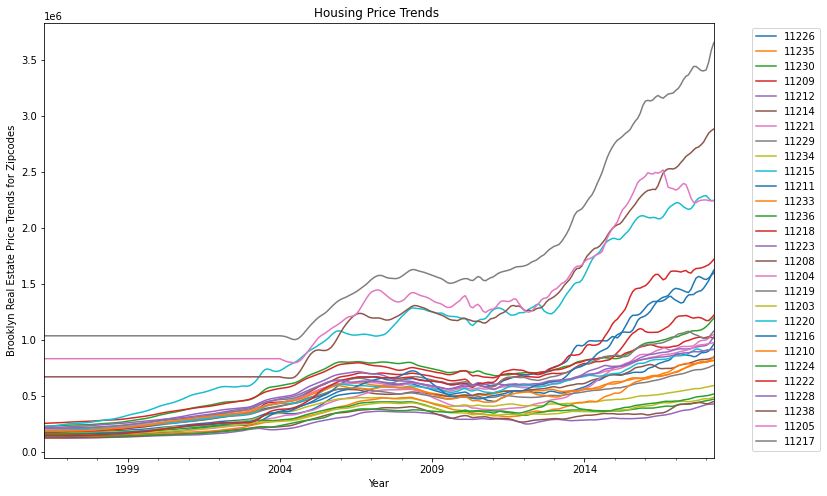

In [25]:
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Brooklyn Real Estate Price Trends for Zipcodes')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

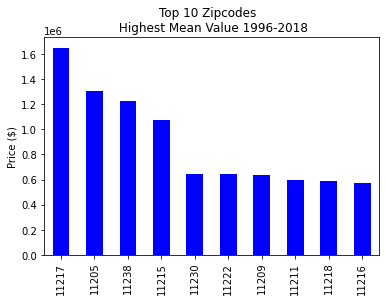

<Figure size 432x288 with 0 Axes>

In [26]:
#zipcode_grp = melted_df.groupby('Zipcode')
mean_value = zip_df.mean()
mean_value = mean_value.sort_values(ascending=False).head(10)
mean_value.plot.bar(color='blue')
plt.title('Top 10 Zipcodes  \n Highest Mean Value 1996-2018')
plt.ylabel('Price ($)')
plt.show()
plt.savefig('Zipcodes')

#### Plot of top 6 zipcodes with highest sale prices over extended periods. 

In [27]:
zip_df_1 = zip_df[[11217, 11238,11215,11216,11222,11205]]

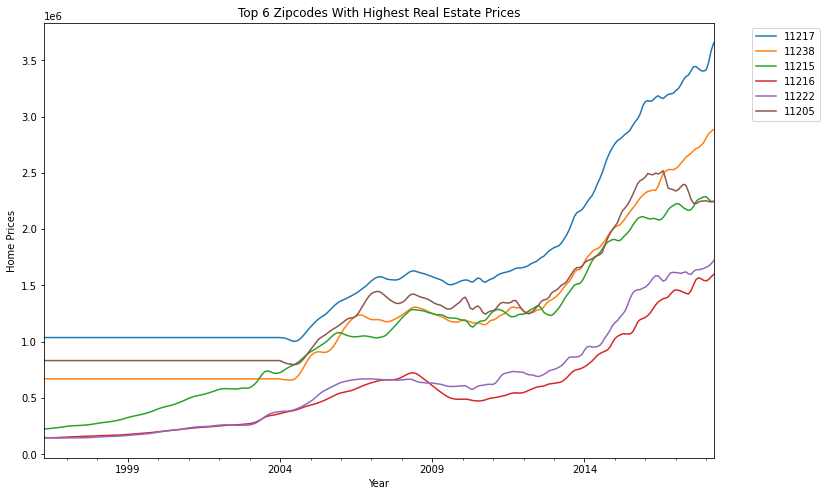

In [28]:
zip_df_1.plot(figsize=(12,8))
plt.title("Top 6 Zipcodes With Highest Real Estate Prices")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

Zipcodes: 11217, 11238, 11205 had the same values for monthly real easte so I created a plot eliminating these dates.  <br>

In [29]:
zip_no_nan = zip_df_1['2003-12-01':] 
zip_no_nan

,11217,11238,11215,11216,11222,11205
Month,,,,,,
2003-12-01,1037600.0,671200.0,720300.0,356700.0,378200.0,833100.0
2004-01-01,1037600.0,671200.0,727100.0,362600.0,380700.0,833100.0
2004-02-01,1035300.0,665400.0,739000.0,368600.0,382000.0,821400.0
2004-03-01,1031400.0,662500.0,754000.0,374200.0,383200.0,812000.0
2004-04-01,1024000.0,660200.0,768600.0,379000.0,384700.0,805500.0
...,...,...,...,...,...,...
2017-12-01,3404100.0,2768900.0,2287100.0,1545700.0,1651200.0,2251000.0
2018-01-01,3413800.0,2810700.0,2288900.0,1540200.0,1661800.0,2251600.0
2018-02-01,3482900.0,2848100.0,2265300.0,1553600.0,1672800.0,2245300.0


In [30]:
zip_describe = zip_no_nan.describe().round(3)
zip_max = zip_describe.max()
zip_max.sort_values(ascending=False)

11217    3656000.0
11238    2885300.0
11205    2519100.0
11215    2288900.0
11222    1721100.0
11216    1598700.0
dtype: float64

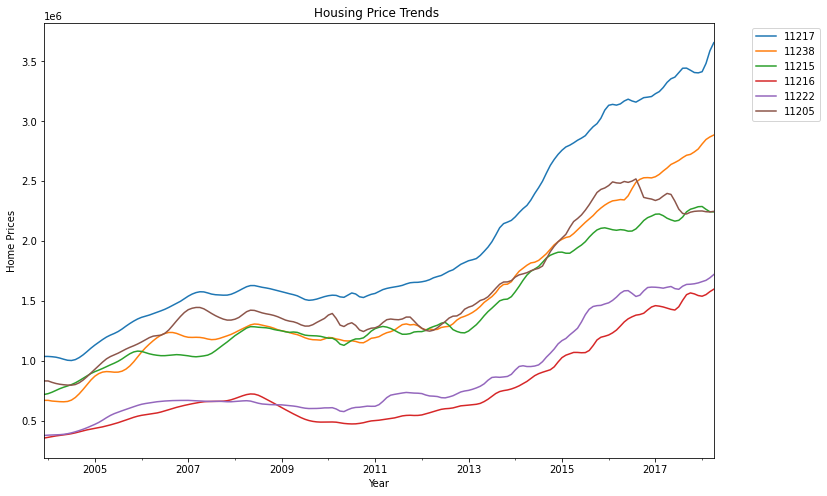

In [31]:
zip_no_nan.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

In [32]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


### **Train/Test Split**
The zip_df dataset will be split into train and test sets to be used as inputs for the models.  Train data set is from 1996–04–01 to 2014–01–01. The length of our train data set is 214 rows, or 214 time periods.<br>
Test data set is from 2014–01–01 to 2018–04–01. The length of the test data is 52 rows, or 52 time periods. 
That is the value we will use for our .predict() method. 

In [33]:
year = '2014-01-01'
train_brk = zip_df.loc[:year]
#test_brk = zip_df.loc[year:]
test_brk = zip_df.loc['2014-01-02':]

In [34]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 28)
(51, 28)


In [35]:
train_brk[11238][[0,-1]]

Month
1996-04-01     671200.0
2014-01-01    1709200.0
Name: 11238, dtype: float64

In [36]:
test_brk.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2014-02-01,590500.0,560000.0,822500.0,822200.0,286800.0,621100.0,577700.0,541600.0,444400.0,1623300.0,...,360700.0,680800.0,792400.0,565400.0,376900.0,954100.0,692700.0,1748800.0,1718500.0,2238400.0
2014-03-01,602600.0,562300.0,823200.0,827400.0,287000.0,632100.0,584600.0,545000.0,446100.0,1673000.0,...,359900.0,684500.0,810600.0,565800.0,372100.0,959900.0,695800.0,1773300.0,1727000.0,2271000.0
2014-04-01,618300.0,566300.0,824000.0,829200.0,286500.0,641600.0,600100.0,548300.0,446500.0,1716700.0,...,358600.0,683300.0,829200.0,564200.0,368400.0,953400.0,696900.0,1798700.0,1736700.0,2298000.0
2014-05-01,632300.0,572000.0,827900.0,830700.0,286400.0,647800.0,619900.0,550600.0,447700.0,1748300.0,...,358900.0,680800.0,852900.0,562100.0,367300.0,953400.0,700100.0,1818100.0,1752000.0,2342400.0
2014-06-01,638900.0,577500.0,833000.0,833900.0,288000.0,653000.0,639600.0,551200.0,449600.0,1767100.0,...,359200.0,677900.0,877300.0,561900.0,366300.0,957600.0,705200.0,1824000.0,1764200.0,2397200.0


In [37]:
test_brk.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [38]:
test_brk[11238][[0,-1]]

Month
2014-02-01    1748800.0
2018-04-01    2885300.0
Name: 11238, dtype: float64

## **Auto_Arima Model**
Why use an Auto_ARIMA model?  We use the auto-ARIMA process because it identifies the optimal parameters for an ARIMA model.  In order to use an ARIMA model it is essential that p,d,q values are inputted into the model.  Generally for an ARIMA model statisical techniques are used to generate these values by performing the difference to eliminate the non-stationarity and obtaining values from ACF and PACF plots.  I would add that the ACF and PACF plots are hard to interpret.<br>

What do p,d and q represent?  The p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.  For example, forecasting that if it rained a lot over the past few days it's likely that it will rain tomorrow as well.<br>  
The d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series, i.e., forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.<br>

The q is the parameter associated with the moving average part of the model.<br>

In the auto ARIMA, the P,D, and Q describe the same associations as p,d, and q, but correspond with the seasonal components of the model.<br>
The auto ARIMA works similar to a grid search to find the optimal values for p, d, and q. The auto ARIMA iterates through all possible combinations of the p,d,q values for each zip code to find out which combination produces the model with the lowest AIC score (best fit).  The final combination of parameters for each zipcode would be determined according the lowest AIC.

In [39]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [40]:
!pip install pmdarima

You should consider upgrading via the '/Users/davidtorres/opt/anaconda3/envs/learn-env/bin/python -m pip install --upgrade pip' command.


In [41]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [42]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
       
    return autoarima_model


In [ ]:
stepwise_fit = arima_model(train_brk[11226])

In [ ]:
stepwise_fit.summary()

### **Dataframe of p,d,qs, Seasonal p,d,qs and lowest AIC**
The for loop iterates through the Brooklyn zipcodes dataframe (zip_df) and uses the arima_model function to get the best fit parameters (p,d,qs, Seasonal p,d,qs) and lowest AICs for each Brooklyn zipcode.  The list, arima_list, is then converted into a Pandas dataframe.  

In [ ]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in zip_df.columns:
  zip_data = arima_model(zip_df[col])
  arima_list.append([col,zip_data.order, zip_data.seasonal_order, zip_data.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

## **SARIMA Model**

### **Fitting a SARIMA Time Series Model**
Using a grid search approach, I used the Auto_Arima model to identify the set of optimal parameters to produce the best fitting model of the time series dataset.  The optimal parameter values are then inputted into the SARIMAX model.  I used a SARIMAX model because it takes into account trends and seasonality.  Acordingly, we can model our data without differencing it and addressing the issue of whether data is stationary or not.<br>    

Coef column shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.<br>

If a weight has a p-value lower or close to 0.05 it is reasonable to retain it in the model.<br>

Model diagnostics - the purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.  N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1).  This is a good indication that the residuals are normally distributed.<br>

In [ ]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

## **Validating the Model**
We're going to see how good our ARIMA model is at forecasting the sale price of homes located in zipcodes 11218 and 11217.  We are going to use One-Step-Ahead Forecasting, Dynamic Forecasting and Out-of-Sample Forecasting with the models to make the forecasting. 

### **One-Step-Ahead Forecasting**

One Step Ahead forecasting means that forecasts at each point are generated using the full history data up to that point to make the prediction.  Forecast one step ahead into the future with the time series.  This allows us to evaluate how good our model is at predicting just one value ahead. 

Confidence intervals show us how confident we are in this time period. 

In order to validate the model, I started by comparing predicted values to real values of the time series.  This will help us understand the accuracy of our forecasts.<br>

The methods .get_prediction() and .conf_int()  allow us to obtain the values and related confidence intervals for the time series forecasts.  The method .get_prediction generates in sample predictions and requires a date so that predictions will be made based on the data up to 1/1/2014. The model is going to make a prediction from the known values.  For this part I wil be  working with the whole dataset and not the train or test sets.<br>

I set the dynamic parameter to false so that the model produces one-step ahead visuals.  The method .conf_int gives us the upper and lower limits on the values of our predictions of the 'pred' object.  This will generate a dataframe of the upper and lower uncertainty range of our prediction. 
    

### Model Diagnostics
In the fit_arima function I included the method '.plot_diagnostics()' to run on the ARIMA output  for a plot of the diagnostics to ensure that none of the assumptions are met. 

The method '.plot_diagnostics()' enables us to confirm whether the residuals remain uncorrelated and normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

The qq-plot on the bottom left shows that for the most part the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1).  This is a strong indication that the residuals are normally distributed.

In [ ]:
def one_step_function(output_df, zipcode_osa=None):
  
    zip_params = output_df[output_df['zipcode']== zipcode_osa]
    zip_params.pdq.values[0]
    zip_params.seasonal_pdq.values[0]

    output_sarima = fit_ARIMA(zip_df[zipcode_osa], order=zip_params.pdq.values[0], seasonal_order=zip_params.seasonal_pdq.values[0])
  #prediction = output_sar.get_forecast(steps=steps, dynamic=True)
    pred = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
    pred_conf = pred.conf_int()
    #prediction.predicted_mean

  # Get confidence intervals of forecasts
   # predict_conf = prediction.conf_int()

    return pred, pred_conf, zipcode_osa, output_sarima


In [ ]:
#zip_params, output_sarima, pred, pred_conf  = one_step_func(output_df, zipcode = 11218,fit_ARIMA())
pred, pred_conf, zipcode_osa,output_sarima =  one_step_function(output_df, zipcode_osa = 11218)

In [ ]:
zip_params = output_df[output_df['zipcode']==11218]
zip_params

In [ ]:
zip_params.columns

In [ ]:
zip_params['pdq']

In [ ]:
zip_params.pdq.values[0]

#### Plot of One-Step-Ahead Forecasting

Below is a plot of the real and forecasted values of the time series to assess how well the model did.  The plot icludes the confidence intervals which in this case overlap the predicted values.  The mean prediction is marked with the orange line.  The uncertainy range is shaded in green.  The uncertainty is due the the random terms that can't be predicted. 

The central value of the forecast is stored in the .predicted_mean attribute of the pred object.

the method .fill_between() produces the shade area between our lower and upper limits.

Visually it looks like the model did pretty good at making the predictions for zipcode 11218 because the forecasts align with the true test set values.

In [ ]:
zip_df[11218].describe().round(2)

In [ ]:
def one_step_plt(train_brk, test_brk,pred, pred_conf, zip=None):
    plt.figure(figsize=(12,5))
    # Plot observed values
    ax = train_brk[zip].plot(label='observed')
    test_brk[zip].plot(label='Test')
    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.title(f'One-Step-Ahead Forecasting for Zipcode {zip}')
    plt.legend();

In [ ]:
one_step_plt(train_brk, test_brk,pred, pred_conf,zip= 11218)

#### Check the Model's Accuracy

I will check the models' accuracy in making the prediction by using the metric RMSE (Mean Squared Error).  RMSE is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are.  RMSE is a measure of how spread out these residuals are. It tells us how concentrated the data is around the line of best fit.

Model was able to forecast the average daily real estate sales in the test set within 10,607.48 of the real sales.  The sales in this zip code 11218 range from around 1,003,700.00 to 2,202,400.00.  

In [ ]:
def metric_function(test_brk, pred_type=None, zip=None):
    # Get the real and predicted values
    forecasted_11238 = pred.predicted_mean
    truth_1128 =test_brk[zip]['1996':]

    # Compute the root mean square error
    mse = ((forecasted_11238 - truth_1128) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
metric_function(test_brk, pred_type= pred, zip= 11218)

In [ ]:
train_brk[zipcode].describe().round(3)

### Dynamic Forecasting

We can make predictions further into the future than just One-Step-Ahead. We predict One-Step-Ahead and use this predicted value to forecast the next value after that.  The forecasts are generated using values from previous forecasted time points. We don't don't know the shock terms after that so the uncertainy level can grow quickly. The more we base the next prediction off of a predicted value the broader the confidence intervals will get.  The farther away we get from last true value the less we can trust the predictions and the more the model is prone to errors.

The dynamic is set to True.

In [ ]:
def dynamic_forcast_func(output_df, zipcode_df=None):
  
    zip_params = output_df[output_df['zipcode']== zipcode_df]
    zip_params.pdq.values[0]
    zip_params.seasonal_pdq.values[0]

    output_sarima = fit_ARIMA(zip_df[zipcode_osa], order=zip_params.pdq.values[0], seasonal_order=zip_params.seasonal_pdq.values[0])
  
    pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    
    return pred_dynamic, pred_dynamic_conf, zipcode_df


In [ ]:
pred_dynamic, pred_dynamic_conf, zipcode_df = dynamic_forcast_func(output_df, zipcode_df=11218)

Plotting the observed and forecasted values of the time series, we see that the Dynamic Forecast displays an upward trend.  The forecast is pretty accurate even when using Dynamic Forecasting.  Model was able to forecast the average daily real estate sales in the test set within 3,724.22 of the real sales.   

In [ ]:

def dynamic_forecast_plot(pred_dynamic,pred_dynamic_conf, train_bk, test_brk, zipcode_df=None):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  #ax = train_bk[zipcode_df].plot(label='Observed')
  ax = train_brk[zipcode_df].plot(label='observed')
  test_brk[zipcode_df].plot(label='Test')  

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.title(f'Dynamic Forecasting for Zipcode {zipcode_df}')  
  plt.legend()

  return ax

In [ ]:
prediction_visual = dynamic_forecast_plot(pred_dynamic,pred_dynamic_conf,train_brk, test_brk, zipcode_df=11218)
prediction_visual

In [ ]:
metric_function(train_brk, pred_type= pred_dynamic, zip= 11218)

### Out-of-Sample Forecasts
I used an ARIMA model to forecast future values beyond the time series.  We need to tell the model how far we are forecasting into the future from the end of the time series dataset.  The .get_forecast() method of our time series output can compute forecasted values for a specified number of steps ahead.  The method .get_forecast() computes the forecasted values for a specified number of steps ahead.  Forecasting much further out into the futre than we had data for.  The farther away we get from the true values the wider the confidence intevals get.

The method .conf_int() gets the confidence intervals of forecasts.

However, we don't just concentrate on predicted mean.  The confidence interval is very wide.  What needs to be considered is that there's a chance that you could lose money by falling to the negtive side of confidence interval.

In [ ]:
def out_sample_forecast(num=None):
    steps = num
    # Get forecast --- steps ahead in future
    prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)
    #prediction_object.predicted_mean
    predict_conf = prediction_object.conf_int()
    
    return prediction_object, predict_conf

In [ ]:
prediction_object, predict_conf = out_sample_forecast(num=300)

In [ ]:
def outside_forecast_plot(prediction_object,predict_conf, y=None, zip_out_df=None):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y[zip_out_df].plot(label='Observed')

  # Plot predicted values
  prediction_object.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(predict_conf.index,
                  predict_conf.iloc[:, 0],
                  predict_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.title(f'Out of Sample Forecast for Zipcode {zip_out_df}') 
  plt.legend()

  return ax

In [ ]:
outside_forecast_plot(prediction_object,predict_conf, y= zip_df, zip_out_df= 11218)

In [ ]:
metric_function(zip_df, pred_type= prediction_object, zip= 11218)

### 11217
Zip code 11217 had the highest real estate prices.  The average price is 1,647,587.925.  The highest price is 3,656,000.00 and the lowest price is 1,003,700.00.

In [ ]:
zip_df[11217].describe().round(3)

### One-Step-Ahead
With One-Step-Ahead the model did very well in forecasting.  The below plot shows that the forecasts follows closely the true value. In applying the metric the model was off 28288.15 im making forecasts.  This is really good considering that the average sale price was 1,647,587.925.

In [ ]:
pred, pred_conf, zipcode_osa,output_sarima =  one_step_function(output_df, zipcode_osa = 11217)

In [ ]:
one_step_plt(train_brk, test_brk,pred, pred_conf,zip= 11217);

In [ ]:
metric_function(test_brk, pred_type= pred, zip= 11217)

In [ ]:
zip_df[11217].describe().round(3)

#### Dynamic Forecast
With Dynamic Forecasts the model also did very well in forecasting.  The below plot shows that the forecasts follows an upward trend. The forecast folllows the true values.  In applying the RMSE metric the model was off 14,900.0 in making forecasts.  This is really good considering that the average sale price was 1,647,587.925.

In [ ]:
pred_dynamic, pred_dynamic_conf, zipcode_df = dynamic_forcast_func(output_df, zipcode_df=11217)

In [ ]:
prediction_visual = dynamic_forecast_plot(pred_dynamic,pred_dynamic_conf,train_brk, test_brk, zipcode_df=11217)
prediction_visual;

In [ ]:
metric_function(train_brk, pred_type= pred_dynamic, zip= 11217)

#### Out-of-Sample Forecasts
With Out-of-Sample Forecasts the model also did very well forecasting.  The below plot shows that the forecasts follows an upward trend.  In applying the metric the model was off 28090.92 in making forecasts.  This is really good considering that the average sale price was 1,647,587.925.  However, the confidence intervals have a very wide span which means that there's a possibility that there could be a loss. 

In [ ]:
prediction_object, predict_conf = out_sample_forecast(num=300)

In [ ]:
outside_forecast_plot(prediction_object,predict_conf, y= zip_df, zip_out_df= 11217)

In [ ]:
metric_function(zip_df, pred_type= prediction_object, zip= 11217)

### **Return on Investment DataFrame (ROI)**
In this section we are going to determine 3 things: 1) What is the ROI on investment for each zipcode? 2)The top 5 zipcodes with the highest ROIs? 3) How ARIMA models performed in forecasting sales prices for top 5 zipcodes with highest ROIs. 

What is a ROI?  ROI is a performance measure used to evaluate the profitability of an investment or compare the efficiency of a number of different investments. ROI tries to directly measure the amount of return on a particular investment, relative to the investment’s cost. 

How is the ROI calculated?  The benefit (or return) of an investment is divided by the cost of the investment. https://www.investopedia.com/terms/r/returnoninvestment.asp 

In [ ]:
steps = 36
# Get forecast -- steps ahead in future
prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)

In [ ]:
def my_function(prediction_object, zip):
  """
  function gets ROI for 1 zipcode 
  """
  df_Summary = pd.concat([pd.DataFrame({f'Predicted_Mean {zip}':prediction_object.predicted_mean}), prediction_object.conf_int()],axis = 1)
  df_Summary

  # 1st and last data point of df_summary
  my_sample = df_Summary.iloc[[0, -1]].round(3)

  return my_sample  #df_Summary

In [ ]:
my_output = my_function(prediction_object, zip='11218')
my_output

In [ ]:
def my_roi(cost, current):
  """  
  function to calculate ROI 
  ROI= 
  Cost of Investment
  Current Value of Investment−Cost of Investment
  """
  return (current - cost) / cost

In [ ]:
# cost = my_output.iloc[0,0]
# current = my_output.iloc[-1,0]

In [ ]:
# current_lower = my_output.iloc[-1,1]
# current_upper = my_output.iloc[-1,2]

In [ ]:
#upper lower end
roi_dic = {}

cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]
current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]

my_roi(cost, current)
roi_dic['roi'] = my_roi(cost, current)
roi_dic['roi_lower'] = my_roi(cost, current_lower)
roi_dic['roi_upper'] = my_roi(cost, current_upper)

roi_dic

In [ ]:
my_output

In [ ]:
zip_rois={}
steps = 36

#def zipcode_roi(output_df,):
for zipcode in output_df['zipcode'].unique():
  pdq = output_df.loc[ output_df['zipcode']==zipcode, 'pdq'].iloc[0] 
  seasonal = output_df.loc[ output_df['zipcode']==zipcode, 'seasonal_pdq'].iloc[0] 
  df_ts = zip_df[zipcode]


  output_sarima = fit_ARIMA(df_ts, order=pdq, seasonal_order=seasonal)
  prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)
  my_output = my_function(prediction_object, zip=zipcode)
  
  roi_dic = {}

  cost = my_output.iloc[0,0]
  current = my_output.iloc[-1,0]
  current_lower = my_output.iloc[-1,1]
  current_upper = my_output.iloc[-1,2]

  my_roi(cost, current)
  roi_dic['roi'] = my_roi(cost, current)
  roi_dic['roi_lower'] = my_roi(cost, current_lower)
  roi_dic['roi_upper'] = my_roi(cost, current_upper)

  zip_rois[zipcode] = pd.Series(roi_dic)
ROI = pd.DataFrame(zip_rois)

In [ ]:
roi_df = ROI.T 
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'zipcode'}, inplace=True)
roi_df.style.background_gradient()

#### **ROI Chart**

In [ ]:
roi_chart_1 = roi_df.sort_values(by=['roi'],ascending=False)
#roi_chart_1 = roi_chart_1.round(3)
roi_chart_1.style.background_gradient()

### **ROI Out-of-Sample Forecasting**
Above we determined what the ROI is for each zipcode and we sorted them from highest and lowest.<br>

We are going to use Out-of-Sample Forecasting for the top 5 zip codes with the highest ROIs. 
We will be using 36 steps for forecasting 36 months into future.  The top 5 zipcodes are:<br>
11223<br>
11210<br>
11230<br>
11224<br>
11233<br>

In [ ]:
def forecast_function(output_df, current_zip=None,steps=None):
  
  zip_params = output_df[output_df['zipcode']==current_zip]
  zip_params.pdq.values[0]
  zip_params.seasonal_pdq.values[0]

  #steps = 36
  output_sar = fit_ARIMA(zip_df[current_zip], order=zip_params.pdq.values[0], seasonal_order=zip_params.seasonal_pdq.values[0])
  prediction = output_sar.get_forecast(steps=steps, dynamic=True)
  prediction.predicted_mean

  # Get confidence intervals of forecasts
  predict_conf = prediction.conf_int()

  return prediction, predict_conf, current_zip

In [ ]:
def forecast_visual(prediction,predict_conf, y, figsize=None):
  """
  prediction-statsmodel object
  predict_conf- pd Dataframe
  """
  print(roi_df[roi_df['zipcode']== current_zip])
  print('\n')
  # Plot future predictions with confidence intervals
  fig,ax = plt.subplots(figsize=figsize)
  ax = y.plot(label='Observed') #(10, 8))
  prediction.predicted_mean.plot(ax=ax, label='Future Forecast')
  ax.fill_between(predict_conf.index,
                  predict_conf.iloc[:, 0],
                  predict_conf.iloc[:, 1], color='k', alpha=0.25)
  
    #I added this and can delete  
    #ax.axvline(prediction.predicted_mean.index[12])

  label_font = {'weight':'bold','size':18}
  ax.set_xlabel('Date',fontdict=label_font)
  ax.set_ylabel('Home Prices',fontdict=label_font)
  ax.set_title(f'Price Forecast for Zipcode: {y.name} /{steps} Months ',fontdict=label_font)

  ax.legend(loc="upper left")

  return ax

### **Zipcode: 11223**
Zipcode 11223 didn't rank in top 10 zipcodes for highest sales prices.  The average price is 553,853.962 and the highest price is 1,026,600.000.  The lowest price is 207,600.000.

Zip code 11223 ranks in 1st place for ROI.  The ROI will be 63% on average.  If an investment is made for a return on the lower end the return will be 16%.  If an investment is made for a return on the upper end the return will be 110.3%.  That is quite a range as far as investments are concerned.  

When forecasting we see that there is also quite a range in the confidence intervals.  There is definitely an upward trend in the forecasting.  This will take you into year 2021 and after.<br>
It looks like a good investment if we rely solely on the ROI as a factor.  However, looking at forecasting we see that there is definitely potential to make and lose money over the long term. 

In [ ]:
#prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11210, steps=36)
#df_test['Btime'].iloc[0]
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[0], steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[0]].plot()

In [ ]:
zip_df[roi_chart_1['zipcode'].iloc[0]].describe()

In [ ]:
zip_df[roi_chart_1['zipcode'].iloc[0]].describe().round(3)

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[0]], figsize=(12,8))
forecast_visual_zip

In [ ]:
metric_function(test_brk, pred_type= prediction, zip= 11223)

### **Zipcode: 11210**
Zipcode 11210 didn't rank in top 5 zipcodes for highest sales prices. The average price is 682,390.20 and the highest price is 819600.00. The lowest price is 561900.00.

Zip code 11210 ranks in 2nd place for ROI. The ROI will be 0.60% on average. If an investment is made for a return on the lower end the return will be -370.7%. If an investment is made for a return on the upper end the return will be  489.905%. That is quite a range as far as investments are concerned. You can make alot of money but you can also lose a lot.

When forecasting we see that there is also quite a range in the confidence intervals. There is a minor upward trend in the forecasting. This will take you into year 2021 and after.
It looks like a good investment if we rely solely on the ROI as a factor.  The prediction looks like it is coming in above the average price.  However, looking at forecasting we see that the confidence intervals are so wide.  There is definitely potential to make and lose money over the long term.

In [ ]:
#zip_df[11210].describe().round(2)
test_brk[11210].describe().round(2)

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[1],steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[1]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[1]], figsize=(12,8))
forecast_visual_zip

In [ ]:
metric_function(zip_df, pred_type= prediction, zip= 11210)

### **Zipcode: 11230**
Zipcode 11230 didn't rank in top 5 zipcodes for highest sales prices. The average price is 644988.68  and the highest price is 1,195,400.00. The lowest price is 230,100.00.

Zip code 11230 ranks in 3rd place for ROI. The ROI will be 46% on average. If an investment is made for a return on the lower end the return will be %12.0491%. If an investment is made for a return on the upper end the return will be  81.5069%. That is quite a range as far as investments are concerned. ROI is reporting positve results overall.

When forecasting we see that there is also quite a range in the confidence intervals. There is quite an upward trend in the forecasting. This will take you into year 2021 and after.
It looks like a good investment if we rely solely on the ROI as a factor.  The prediction looks like it is coming in above the average price.  However, looking at forecasting we see that the confidence intervals are so wide.  There is definitely potential to make and lose money over the long term.

In [ ]:
zip_df[11230].describe().round(2)

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[2],steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[2]].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[2]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[2]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11224**
Zipcode 11224 didn't rank in top 5 zipcodes for highest sales prices. The average price is 305,133.96 and the highest price is 517,900.00. The lowest price is 142,400.00.

Zip code 11224 ranks in 4th place for ROI. The ROI will be 0.456% on average. If an investment is made for a return on the lower end the return will be  -57.4688%. If an investment is made for a return on the upper end the return will be 148.738%. That is quite a range as far as investments are concerned. ROI is reporting both negative and positve results overall.

When forecasting we see that there is also quite a range in the confidence intervals. There is quite an upward trend in the forecasting. This will take you into year 2021 and after. It looks like a good investment if we rely solely on the ROI as a factor. The prediction looks like it is coming in above the steadily above the average price. However, looking at forecasting we see that the confidence intervals are so wide. There is definitely potential to make and lose money.

In [ ]:
zip_df[11224].describe().round(2)

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[3],steps=36)

In [ ]:
test_brk[11230].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[3]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[3]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11233**
Zipcode 11233 didn't rank in top 5 zipcodes for highest sales prices. The average price is  363,811.321 and the highest price is 852,300.000. The lowest price is 124,500.00.

Zip code 11233 ranks in 5th place for ROI. The ROI will be 42.67% on average. If an investment is made for a return on the lower end the return will be  5.3068%. If an investment is made for a return on the upper end the return will be 80.04%. That is quite a range as far as investments are concerned. ROI is reporting positve results overall.  It looks like a good investment if we rely solely on the ROI as a factor. 

When forecasting we see that there is also quite a range in the confidence intervals. There is quite an upward trend in the forecasting. This will take you into year 2021 and after. The prediction looks like it is coming in above the steadily above the average price. However, looking at forecasting we see that the confidence intervals are so wide. There is definitely potential to make and lose money.

In [ ]:
zip_df[11233].describe().round(3)

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[4],steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[4]].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[4]].plot()

In [ ]:

forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[4]], figsize=(12,8))
forecast_visual_zip

## ***Stationarity***

### **Zipcode: 11226**

In [ ]:
zip_df[11226].plot()

In [ ]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

In [ ]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [ ]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

In [ ]:
new_dic[11226]

In [ ]:

def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [ ]:
dickey_fuller_test_zipcodes(zip_df)

In [ ]:
X_1 = zip_df.copy()

In [ ]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

In [ ]:
stationary_test(zip_df[11226])

###  Zipcode:  11238

In [ ]:
#brooklyn_zips[11226]

In [ ]:
#stationary_test(zip_df[11238])

### Zipcode:  11215

In [ ]:
stationary_test(zip_df[11226])

### Removing Trend
#### Log-Transformation (np.log)

In [ ]:
## Log Transform
ts3 = np.log(zip_df[11226])
#ts3.plot()
stationary_test(ts3)

#### Differencing

In [ ]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11226].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

In [ ]:
## Subtract Rolling mean
ts2 = (zip_df[11226] - zip_df[11226].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

In [ ]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11226] - zip_df[11226].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11226])#,model='mul')
decomp.plot();

In [ ]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

In [ ]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

In [ ]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [ ]:
decomp.resid.dropna()

## **RNN**
This section concerns using a Recurrent Nueral Network to forecast sale prices.

In [ ]:
df_rnn = zip_df[[11238]]

In [ ]:
df_rnn.head()

In [ ]:
df_rnn.plot()

In [ ]:
len(df_rnn)

In [ ]:
265-12

In [ ]:
"""
x_train= x_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
"""
train = df_rnn.iloc[:253]
test = df_rnn.iloc[253:]
#test = test.reshape(1, -1)
#train= train.reshape(-1, 1)

In [ ]:
test

In [ ]:
len(test)

In [ ]:
train.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 2
n_features = 1 #smaller batch sizes lead to better training

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
scaled_train[:5]

In [ ]:
len(scaled_train)

In [ ]:
"""

253 - n_input(2)

"""
len(generator)

In [ ]:
# #create model and fit it to the generator object
# from keras.models import Sequential
# from keras.layers import Dense  #for final output later
# from keras.layers import LSTM #long short term memory

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
n_input = 12 #look at full year of data or 12 months before predicting 13th month
n_features = 1 #smaller batch sizes lead to better training
               #how many columns you have. WE have 1 column which is time stamp for y

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
"""
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#need to aggregate all the neurons to sngle prediciton
model.add(Dense(1)) #added single dense neuron which will directly output our prediction
model.compile(optimizer='adam', loss='mse')

"""
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#need to aggregate all the neurons to sngle prediciton
model.add(Dense(1)) #added single dense neuron which will directly output our prediction
model.compile(optimizer='adam', loss='mse')

In [ ]:
"""
may want to play around w/number of neurons on LSTM layer
"""
model.summary()

In [ ]:
"""
fit tou our training generator
more epochs you use hte longer it's going to take to train
1 epoch is a single entire run through of training data

We get significant reduciton over 1st couple of epochs then around 15 start seeing convergence

"""
model.fit_generator(train_generator, epochs=25)

In [ ]:
model.history.history.keys()

In [ ]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss']);

In [ ]:
"""
evalute on the test data
create an evlauation batch
our network trains 1 step ahead

our network is 12 network steps 
    then predict step 13
    
need last 12 points of training data inorder to predict pt. 1 of test data 

these are last 12 points of training set
"""
first_eval_batch = scaled_train[-12:]
first_eval_batch

In [ ]:
"""
it now has 3 brackets at the top
"""
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))
first_eval_batch

In [ ]:
"""
call model on first_eval_batch
gives array prediciton
means given these 12 points of training data it predicts taht below should be 1st point of test data set
"""
model.predict(first_eval_batch)

In [ ]:
scaled_test

In [ ]:
"""
not just predict 1st point in test set but the entire test set
how to forecast into the future
Forecast using RNN model
"""
#hold predicitons
test_predictions = []
#last n_input points from training set
first_eval_batch = scaled_train[-n_input:] 
#reshape to format of RNN wants, (same format as Timeseriesgenerator 
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#hoe far into the futrue will I forecast: length of test set
for i in range(len(test)):
    #1time step ahead of historical 12 points
    current_pred = model.predict(current_batch)[0] #0 is for formatting 
    test_predictions.append(current_pred)
    
    #update current batch to include prediciton
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

### **RNN Plot / Sales v Predicted Values**

In [ ]:
"""
sales v predicted values
"""
test.plot(figsize=(12,5));

### **Findings and Recommendations**

#### ARIMA Models

In [ ]:
data = {
        'One-Step':        [10698.27, 28288.15],
        'Dynamic':         [3724.22,14900.00],
        'Forecasting':     [10607.48,28090.92]}

df_rmse = pd.DataFrame(data, index =['11218',
                                '11217'])
df_rmse

I created ARIMA models to forecast sale prices of properties located in Brooklyn, NY.  I used the auto arima class as a grid search to determine the best p,d,q values and asssociated lowest AIC score for each zipcode.  I used two zip codes to see how ARIMA models performed with this data in forecasting. I used One-Step-Ahead Forecasting, Dynamic Forecasting and Out-of-sample Forecasts.  I evaluated  how the ARIMA models performed with the RMSE metric zipcodes 11218 and 11217.  

Overall the models performed really well.  For zip code 11218 the average price was 590,361.51.  One-Step-Ahead forecast, the model was off 10,698.27 when making predictions.  Dynamic Forecasting, the model was off 3,724.22.  

#### ROIs

In [ ]:
data = {
        'ROI':         [0.63,0.60,0.47,0.46,0.43],
        'LOW':         [0.1624,-3.7076,0.12049,0.5746,0.05306],
        'High':         [1.103,4.89905,0.815069,1.487380,0.800404]}

df_roi = pd.DataFrame(data, index =['11223',
                                '11210',
                                '11230',
                                '11224',
                                '11233'])
df_roi

Above are the Brooklyn zipcodes with the Top 5 ROIs.  What\'s interesting is that none of the top 5 zipcodes with the highest ROIs were in the top 5 zip codes with the highest 
sales prices.  For example, zipcode 11223 had the highest ROI of 63%.  On the low side 11223 had an ROI of 16% and on the high side 
an ROI of 110.3%.  The ROI was in the positive which is important.  Only zipcode 11210 reported a negative ROI on the low side.<br>

The zipcode 11217, had the reported highest sale price but only ranked in the middle of  ROI chart 	of 26.1374%	with low of 14.8246% and high  37.4503% which is still pretty good. 

I recommend investing in the top zip codes because the ROI calculations are reporting positive returns either on the low end or the high end. 